In [494]:
import pandas as pd
import re
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer

# Data Preprocessing

### Load Train Data

In [495]:
df_train = pd.read_csv("train.csv")

In [496]:
df_train.head()

,TweetId,Label,TweetText
0,304271250237304833,Politics,'#SecKerry: The value of the @StateDept and @U...
1,304834304222064640,Politics,'@rraina1481 I fear so'
2,303568995880144898,Sports,'Watch video highlights of the #wwc13 final be...
3,304366580664528896,Sports,'RT @chelscanlan: At Nitro Circus at #AlbertPa...
4,296770931098009601,Sports,'@cricketfox Always a good thing. Thanks for t...


### Change Label Column Values

In [497]:
df_train['Label'] = df_train['Label'].map({'Politics': 1, 'Sports': 0})

In [498]:
df_train.head()

,TweetId,Label,TweetText
0,304271250237304833,1,'#SecKerry: The value of the @StateDept and @U...
1,304834304222064640,1,'@rraina1481 I fear so'
2,303568995880144898,0,'Watch video highlights of the #wwc13 final be...
3,304366580664528896,0,'RT @chelscanlan: At Nitro Circus at #AlbertPa...
4,296770931098009601,0,'@cricketfox Always a good thing. Thanks for t...


### Drop TweetId Column

In [499]:
df_train.drop("TweetId", axis='columns')

,Label,TweetText
0,1,'#SecKerry: The value of the @StateDept and @U...
1,1,'@rraina1481 I fear so'
2,0,'Watch video highlights of the #wwc13 final be...
3,0,'RT @chelscanlan: At Nitro Circus at #AlbertPa...
4,0,'@cricketfox Always a good thing. Thanks for t...
...,...,...
6520,1,'Photo: PM has laid a wreath at Martyrs Monume...
6521,0,'The secret of the Chennai pitch - crumbling o...
6522,0,@alinabhutto he isn't on Twitter either
6523,0,'Which England player would you take out to di...


In [500]:
df_train['TweetText'][0]

"'#SecKerry: The value of the @StateDept and @USAID is measured, not in dollars, but in terms of our deepest American values.'"

### Preprocess Tweet Text

In [501]:
def Preprocess_a_Tweet(tweet):
        tweet = tweet.lower()
        tweet = re.sub(r'[^\w\s]', '', tweet)
        tweet = re.sub(r'http\S+', '', tweet)
        words = word_tokenize(tweet)
        stop_words = set(stopwords.words('english'))
        words = [word for word in words if word not in stop_words]
        lemmatizer = WordNetLemmatizer()
        words = [lemmatizer.lemmatize(word) for word in words]
        return ' '.join(words)

In [502]:
df_train['TweetText'] = df_train['TweetText'].apply(Preprocess_a_Tweet)

In [503]:
df_train['TweetText'][0]

'seckerry value statedept usaid measured dollar term deepest american value'

### Feature Extraction Using BoW

In [504]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt

In [505]:
vectorizer = CountVectorizer()

In [506]:
X = vectorizer.fit_transform(df_train['TweetText'])

In [507]:
y = df['Label']

### Split Data Train/Test

In [508]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
labels = {1 : "Politics", 0 : "Sports"}

# Data Visualisation

### Tweets Distribution Bar Chart

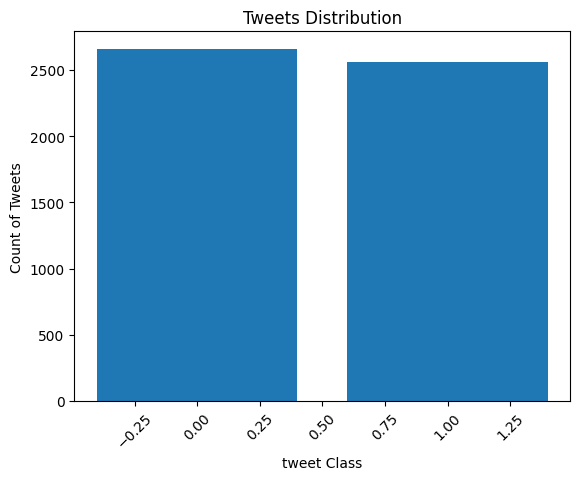

In [509]:
class_distribution = y_train.value_counts()
plt.bar(class_distribution.index, class_distribution.values)
plt.xlabel('tweet Class')
plt.ylabel('Count of Tweets')
plt.title('Tweets Distribution')
plt.xticks(rotation=45)
plt.show()

### Top 10 Most Used Words in Tweets

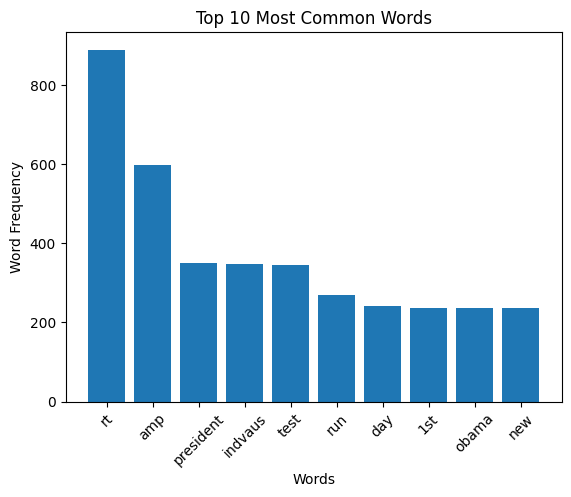

In [510]:
from collections import Counter

tokens = " ".join(df['TweetText']).split()
word_counts = Counter(tokens)

common_words = word_counts.most_common(10)  

words, counts = zip(*common_words)

plt.bar(words, counts)
plt.xlabel('Words')
plt.ylabel('Word Frequency')
plt.title('Top 10 Most Common Words')
plt.xticks(rotation=45)
plt.show()


# ML Model

### Load and Train Naive Bayes Model 

In [511]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import roc_curve
from sklearn.metrics import confusion_matrix,accuracy_score, precision_score, recall_score, f1_score


nb_model = MultinomialNB()
nb_model.fit(X_train, y_train)

MultinomialNB()

### Test Model

In [512]:
predicted_labels = nb_model.predict(X_test)

In [513]:
accuracy = accuracy_score(y_test, predicted_labels)
precision = precision_score(y_test, predicted_labels)
recall = recall_score(y_test, predicted_labels)
f1 = f1_score(y_test, predicted_labels)

In [514]:
print("Accuracy : ",accuracy, " \nPrecision : ", precision, " \nRecall : ", recall, " \nF1 Score : ",f1)

Accuracy :  0.9616858237547893  
Precision :  0.959375  
Recall :  0.9623824451410659  
F1 Score :  0.9608763693270735


### Confusion Matrix

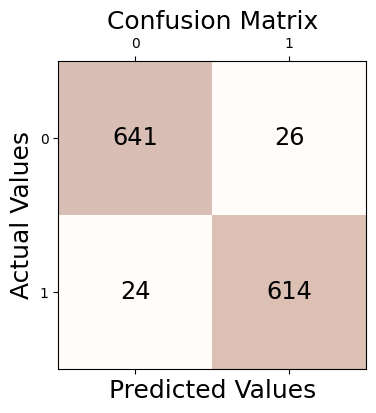

In [515]:
matrix = confusion_matrix(y_true=y_test, y_pred=predicted_labels)
fig, ax = plt.subplots(figsize=(4, 4))
ax.matshow(matrix, cmap=plt.cm.Oranges, alpha=0.3)
for i in range(matrix.shape[0]):
    for j in range(matrix.shape[1]):
        ax.text(x=j, y=i,s=matrix[i, j], va='center', ha='center', size='xx-large')

plt.xlabel('Predicted Values', fontsize=18)
plt.ylabel('Actual Values', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

### ROC Curve chart

In [516]:
y_scores = nb_model.predict_proba(X_test)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, y_scores)

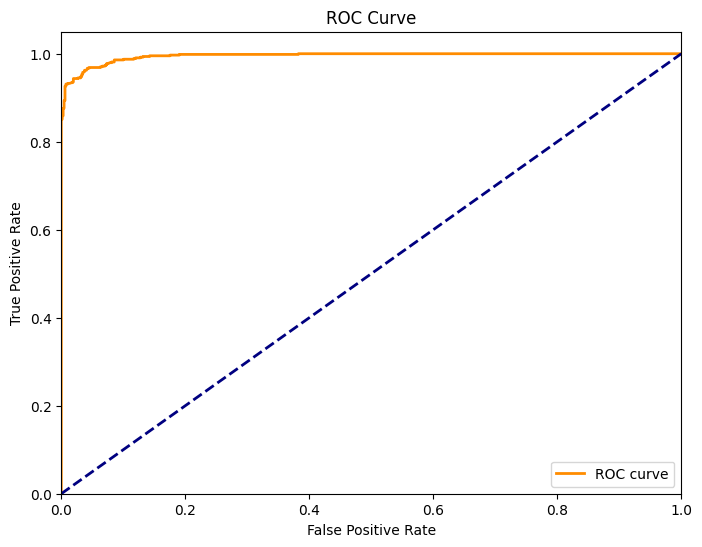

In [517]:
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

In [518]:
df_test = pd.read_csv("test.csv")

In [519]:
df_test.head()

,TweetId,TweetText
0,306486520121012224,'28. The home side threaten again through Maso...
1,286353402605228032,'@mrbrown @aulia Thx for asking. See http://t....
2,289531046037438464,'@Sochi2014 construction along the shores of t...
3,306451661403062273,'#SecKerry\u2019s remarks after meeting with F...
4,297941800658812928,'The #IPLauction has begun. Ricky Ponting is t...


In [520]:
input_vector = vectorizer.transform([df_test['TweetText'][3]])
predicted_label = nb_model.predict(input_vector)[0]

In [521]:
print(df_test['TweetText'][3], "\nLabel : ", labels[predicted_label])

'#SecKerry\u2019s remarks after meeting with Foreign Minister Westerwelle. Transcript: http://t.co/B2J8GGfxhP | Video: http://t.co/4Qx0FhYpmP' 
Label :  Politics


In [522]:
input_vector = vectorizer.transform([df_test['TweetText'][2]])
predicted_label = nb_model.predict(input_vector)[0]

In [523]:
print(df_test['TweetText'][2], "\nLabel : ", labels[predicted_label])

'@Sochi2014 construction along the shores of the Black Sea http://t.co/8dVIn7wJ' 
Label :  Politics


### Save predictions in a file

In [524]:
X = vectorizer.transform(df_test['TweetText'])

In [525]:
pred_labels = nb_model.predict(X)

In [526]:
df_test['Label'] =  [labels[prediction] for prediction in pred_labels]
df_test = df_test.drop("TweetText", axis='columns')

In [527]:
df_test.to_csv('test_predictions.csv', index=False)